In [2]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import SimpleITK as sitk
import skimage
import os
join = os.path.join
import pandas as pd
import cv2
import h5py
import pandas as pd


In [4]:
root_path = "/data3/home/lishengyong/data/ssc/2D_bbox/processed_data/zoom_rotate_train/img_embadding"
pred_path = "/data3/home/lishengyong/data/ssc_0802/pred.files/processed_csv"
nii_path = "/data3/home/lishengyong/data/ssc_0802/nii.gz.files"
files = [i for i in Path(root_path).iterdir()]
files.sort()
for i in Path("/data3/home/lishengyong/data/ssc_0802/h5.files/processed_h5").iterdir():
    if i.is_dir():
        continue
    print(i.name)
    with h5py.File(i, 'r') as f: #打开h5文件
        # for key in f.keys():
            # print(key, f[key].shape)
        print(f["masks"][:].shape)
        print(f["datas"][:].shape)
    # roi_path = str(i).replace("h5", "nii.gz")
    # roi = sitk.ReadImage(roi_path)
    # csv_path = str(i).replace("h5", "pred").replace("ssc_0802", "ssc")
    # print(roi.GetSize()[2]/9)
    # df = pd.read_csv(csv_path, sep="\t", header=None).iloc[:, [0, 3]]

        
    



lidc.bad.mask.size.after.adjust.h5
(299, 128, 128, 64)
(299, 128, 128, 64)
merged_large.bad.mask.size.after.adjust.h5
(1624, 128, 128, 64)
(1624, 128, 128, 64)
bm.size.bad.mask.size.after.adjust.h5


In [12]:
import nibabel as nib
import SimpleITK as sitk
for i in Path("/data3/home/lishengyong/data/ssc_0802/slices/infer_3d/axis_0/trans_images").iterdir():
    img = nib.load(i)
    img_arr = np.transpose(img.get_fdata(), (2, 1, 0))
    nib.save(nib.Nifti1Image(img_arr, None), i)
    

In [14]:
# h5数据大小
root = "/data3/home/lishengyong/data/ssc"
h5_root = ""
with h5py.File("/data2/home/zoulongkuan/lung_nodule/ssc/h5.files/nodules.list.rj.20230703.pred.h5", 'r') as f:
    for key in f.keys():
        print(key, f[key].shape)

centers (6680, 3)
datas (6680, 128, 128, 16)
lung_masks (6680, 128, 128, 16)
masks (6680, 128, 128, 16)
names (6680,)
spacings (6680, 3)


In [13]:
import torch
show_img = torch.Tensor([1,2,3,4,5])
show_img = (show_img - show_img.min()) / (show_img.max() - show_img.min())
print(show_img)

tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])


In [16]:
import os
data_path = "/data2/home/zoulongkuan/lung_nodule/ssc/h5.files/lung_false_positive_batch2.4_marker_2021.0422.0623_tp.train.fix_bug_2022.9.22.txt.h5"
names = os.listdir("/data3/home/lishengyong/data/ssc/new724/masks")
ls = []
with h5py.File(data_path, "r") as file:
    for j in range(len(file["centers"])):
        single_name = f"{str(file['names'][j])[2:-1]}_{file['centers'][j]}.nii.gz"
        ls.append(single_name)

print(len(set(ls)))

15346


In [22]:
def show_img_label(img_array, roi_array, show_index=None):
    if show_index != None:
        show_img = img_array[show_index, ...]
        show_roi = roi_array[show_index, ...]
    else:
        show_img = img_array
        show_roi = roi_array
    # plt.axis('off')
    plt.imshow(show_img, cmap='gray')
    plt.contour(show_roi)
    #plt.show()
    
def connection_test(roi_array, show_index):
    show_roi = roi_array[show_index, ...]
    labels = skimage.measure.label(show_roi,connectivity=2)
    if labels.max() != 0:
        print(labels.max())



In [ ]:
# 找最大层
nii_root = Path(root+"/nii.gz.files")
for img_path in nii_root.glob("*data.nii.gz"):
    if "lung_false_positive_batch2.big.than" in img_path.name:
        continue
    if "lidc.center" in img_path.name:
        continue
    img = sitk.ReadImage(str(img_path))
    img_array = sitk.GetArrayFromImage(img)
    roi = sitk.ReadImage(str(img_path).replace("data.nii.gz", "mask.nii.gz"))
    roi_array = sitk.GetArrayFromImage(roi)
    # roi_index = [i for i, e in enumerate(np.sum(roi_array, axis=(1, 2)).tolist()) if e != 0]
    for i in range(roi_array.shape[0]):
        labels = skimage.measure.label(roi_array[i, ...],connectivity=2)
        if labels.max() == 2:
            show_img_label(img_array, roi_array, i)
            print(img_path.name)
            print(labels.max())
    # print(roi_array.shape[0] / len(roi_index))

In [14]:

def crop_pad(single_slice):
    # 切出最大连通区域并移动到中间
    
    # 判断是否空的
    if np.sum(single_slice) == 0:
        return np.zeros([128, 128])
    labels = skimage.measure.label(single_slice, connectivity=2)
    props = skimage.measure.regionprops(labels)

    numPix = []
    for ia in range(len(props)):
        numPix += [props[ia].area]
    maxnum = max(numPix)
    index = numPix.index(maxnum)

    #最大连通区域的bounding box
    minr, minc, maxr, maxc = props[index].bbox
    bbox = single_slice[minr:maxr, minc:maxc]
    row_range = maxr - minr
    col_range = maxc - minc
    row_pad = 64-(row_range // 2)
    col_pad = 64-(col_range // 2)
    if row_range % 2 == 0 and col_range % 2 == 0: 
        new_slice = np.pad(bbox, ((row_pad, row_pad), (col_pad, col_pad)), 'constant')
    elif row_range % 2 != 0 and col_range % 2 == 0:
        new_slice = np.pad(bbox, ((row_pad, row_pad-1), (col_pad, col_pad)), 'constant')
    elif row_range % 2 == 0 and col_range % 2 != 0:
        new_slice = np.pad(bbox, ((row_pad, row_pad), (col_pad, col_pad-1)), 'constant')
    else:
        new_slice = np.pad(bbox, ((row_pad, row_pad-1), (col_pad, col_pad-1)), 'constant')
    return new_slice



def pad0(single_slice):
    # 除了最靠近中心的连通区域以外填0
    
    # 判断是否空的
    if np.sum(single_slice) == 0:
        return np.zeros([128, 128])
    labels = skimage.measure.label(single_slice, connectivity=2)
    props = skimage.measure.regionprops(labels)

    numPix = []
    for ia in range(len(props)):
        x, y = props[ia].centroid
        length = (x-64)*(x-64) + (y-64)*(y-64)
        numPix.append(length)
    maxnum = min(numPix)
    index = numPix.index(maxnum)
    if index != 0:
        print(index)
    minr, minc, maxr, maxc = props[index].bbox
    mask = np.zeros((128, 128))
    mask[minr:maxr, minc:maxc] = 1
    return mask * single_slice


In [114]:
nii_root = Path("/data3/home/lishengyong/data/ssc/nii.gz.files/processed_data")
for img_path in nii_root.iterdir():
    if ("lung_false_positive_batch2.4_marker.1618" in img_path.name) or ("lidc.center" in img_path.name):
        roi = sitk.ReadImage(str(img_path).replace("data.nii.gz", "mask.nii.gz"))
        roi_array = sitk.GetArrayFromImage(roi)
        new_roi_array = []
        for i in roi_array:
            new_roi_array.append(crop_pad(i))
        new_roi = sitk.GetImageFromArray(np.array(new_roi_array))
        sitk.WriteImage(new_roi, str(img_path))

In [ ]:


for img_path in nii_root.glob("*data.nii.gz"):
    if "lung_false_positive_batch2.4_marker.1618" in img_path.name:
        continue
    if "lidc.center" in img_path.name:
        continue
    # img = sitk.ReadImage(str(img_path))
    # img_array = sitk.GetArrayFromImage(img)
    roi = sitk.ReadImage(str(img_path).replace("data.nii.gz", "mask.nii.gz"))
    roi_array = sitk.GetArrayFromImage(roi)
    print(img_path.name, roi_array.shape)
    new_roi = []
    new_roi_index = []
    for i in range(roi_array.shape[0] // 9):  #roi_array.shape[0] // 9
        j = 9 * i
        single_roi_array = roi_array[j:j+9, ...]
        slices = []
        sums = []
        for slice in single_roi_array:
            if np.sum(slice) != 0:
                if np.sum(slice) > 9000:
                    new_slice = np.zeros((128, 128))
                else:
                    new_slice = crop_pad(slice)
                    # plt.imshow(new_slice)
                    # plt.show()
            else:
                new_slice = np.zeros((128, 128))
            slice_sum = np.sum(new_slice)
            slices.append(new_slice)
            sums.append(slice_sum)
        max_index = sums.index(max(sums))
        # if np.sum(slices[max_index]) == 0:
        #     print(img_path.name, max_index+j, "no liantong")
        #     print([np.sum(slice) for slice in single_roi_array])
        #         # plt.imshow(slice)
        #         # plt.show()
        #     continue
        if slices[max_index].shape != (128, 128):
            print(img_path.name, max_index+j, slices[max_index].shape)
            continue
        new_roi.append(slices[max_index])
        new_roi_index.append(max_index + j)
    new_roi_array = np.array(new_roi)
    new_roi_save = sitk.GetImageFromArray(new_roi_array)
    print(len(new_roi_index))
    sitk.WriteImage(new_roi_save, str(img_path).replace("data.nii.gz", "mask_pro.nii.gz"))
    with open(str(img_path).replace("data.nii.gz", ".txt"), "w") as f:
        for line in new_roi_index:
            f.write(str(line)+'\n')
        
            
            


In [2]:
# mapping
file_path = "/data3/home/lishengyong/data/ssc/h5.files/lung_false_positive_batch2.4_marker.1618.center.nodule.pred.h5"
def file_mapping(file_path):
    f = h5py.File(file_path, 'r') #打开h5文件
    # 创建h5文件names和centers字段的df
    f_dict = {}
    f_dict["centers"] = [str(i).replace(" ", ",").replace(",,",",")[1:-1].strip(",") for i in f["centers"]]
    f_dict["names"] = f["names"]
    h5_df = pd.DataFrame.from_dict(f_dict)
    # 创建name+center字段用于merge
    h5_df["names+centers"] = [str(i[0])[2:-1]+"+"+str(j).replace(",,",",") for i, j in zip(h5_df["names"], h5_df["centers"])]
    # 读取pred表格
    pred_path = file_path.replace("h5.files", "pred.files")[:-3]
    nii_df = pd.read_csv(pred_path, sep="\t", header=None).iloc[:, [0, 3]]
    nii_df.columns = ["names", "centers"]
    nii_df["nii_index"] = range(len(nii_df))
    nii_df["names+centers"] = [os.path.basename(i).replace("npz", "zarr")+"+"+str(j) for i, j in zip(nii_df["names"], nii_df["centers"])]
    nii_df.drop_duplicates(subset=['names+centers'],keep='first',inplace=True)
    # 合并的时候应该以h5文件为主
    index_df = pd.merge(h5_df, nii_df, how="left", on=["names+centers"])
    # 读取nii文件
    mask = sitk.ReadImage(file_path.replace("h5", "nii.gz").replace("files", "files/processed_data"))
    mask_array = sitk.GetArrayFromImage(mask)
    mask_list = [-1] * len(h5_df)
    for i, j in enumerate(index_df["nii_index"]):
        if not pd.isna(j):
            mask_list[i] = mask_array[int(j), ...]
        else:
            print(i)
    if len(mask_list) != len(h5_df):
        print(len(mask_list), len(h5_df))
        return None
    # 保存文件
    index_df.to_csv(file_path.replace("h5.files", "pred.files/processed_csv").replace("pred.h5", "csv"))
    store_path = file_path.replace("h5.files", "h5.files/processed_h5")
    print(store_path)
    new_f = h5py.File(store_path, "w-")
    for key in f.keys():
        new_f[key] = f[key][:]
    new_f["gt"]=np.array(mask_list)
    new_f.close()
    f.close()
    print("set one")
file_mapping(file_path)



/data3/home/lishengyong/data/ssc/h5.files/processed_h5/lung_false_positive_batch2.4_marker.1618.center.nodule.pred.h5
set one


In [3]:
root = "/data3/home/lishengyong/data/ssc/h5.files"
for file in os.listdir(root):
    if os.path.isfile(os.path.join(root, file)):
        print(file)
        file_mapping(os.path.join(root, file))

lung_false_positive_batch2.4_marker.1618.center.nodule.pred.h5
/data3/home/lishengyong/data/ssc/h5.files/processed_h5/lung_false_positive_batch2.4_marker.1618.center.nodule.pred.h5
set one
lung_false_positive_batch2.big.than.8.after.adjust.pred.h5
/data3/home/lishengyong/data/ssc/h5.files/processed_h5/lung_false_positive_batch2.big.than.8.after.adjust.pred.h5
set one
merged_large.bad.mask.size.after.adjust.pred.h5
/data3/home/lishengyong/data/ssc/h5.files/processed_h5/merged_large.bad.mask.size.after.adjust.pred.h5
set one
bm.size.bad.mask.size.after.adjust.pred.h5
/data3/home/lishengyong/data/ssc/h5.files/processed_h5/bm.size.bad.mask.size.after.adjust.pred.h5
set one
lidc.bad.mask.size.after.adjust.pred.h5
/data3/home/lishengyong/data/ssc/h5.files/processed_h5/lidc.bad.mask.size.after.adjust.pred.h5
set one
lidc.center.nodule.pred.h5
/data3/home/lishengyong/data/ssc/h5.files/processed_h5/lidc.center.nodule.pred.h5
set one


In [25]:
import json
file_path = "/data3/home/lishengyong/data/ssc_0802/h5.files/processed_h5"
with open("/data3/home/lishengyong/data/ssc/h5.files/ssc_spacing.json", "r") as json_file:
    spacings = json.load(json_file)
for file in Path(file_path).iterdir():
    print(file.name)
    new_spacings = []
    with h5py.File(file, 'r+') as f:#打开h5文件
        for i in f["names"][:]:
            new_name = i[0].decode("utf-8")
            new_spacing = spacings[new_name]
            new_spacings.append(new_spacing)
    
        f["new_spacings"] = np.array(new_spacings)


lidc.bad.mask.size.after.adjust.h5
merged_large.bad.mask.size.after.adjust.h5
bm.size.bad.mask.size.after.adjust.h5
lidc.center.nodule.after.adjust.h5
lung_false_positive_batch2.big.than.8.after.adjust.h5
lung_false_positive_batch2.4_marker.1618.center.nodule.h5


In [6]:
import json
with open("/data3/home/lishengyong/data/ssc/h5.files/ssc_spacing.json", "r") as json_file:
    spacings = json.load(json_file)

a = []    
for key, value in spacings.items():
    a.append(value[2] / value[1])


In [ ]:
file_path = "/data3/home/lishengyong/data/ssc/h5.files/new_processed"
for file in Path(file_path).iterdir():
    print(file.name)
    with h5py.File(file, 'r+') as f:
        new_masks, new_gts, shanchu = [], [], []
        for i in range(len(f["names"])):
            new_mask = []
            for j in range(64):
                new_mask.append(pad0(f["masks"][i][..., j]))
            if np.sum(new_mask[32]) == 0:
                shanchu.append(i)
            new_masks.append(np.array(new_mask))
            new_gt = np.flip(np.rot90(f["gt"][i]), axis=0)
            new_gts.append(new_gt)
        del f["masks"]
        del f["gt"]
        f["masks"] = new_masks
        f["gts"] = new_gts
        for key in f.keys():
            new_data = np.delete(f[key][:], shanchu, axis=0)
            del f[key]
            f[key] = new_data


In [11]:
# 把h5文件切片
store_path = "/data3/home/lishengyong/data/ssc_0802/new_slices"
def write(a, path, spacing=None):
    b = sitk.GetImageFromArray(a)
    if spacing is not None:
        b.SetSpacing(spacing=spacing)
    sitk.WriteImage(b, path)
for i in ["images", "masks", "labels", "3D_images", "3D_masks"]:  #, "labels", "3D_images", "3D_masks"
    os.makedirs(os.path.join(store_path, i), exist_ok=True)
    
    
def section(i):    
    file = h5py.File(i, "r")
    k = 0
    for j in range(len(file["centers"])):
        if file["masks"][j].shape[2] == 64:
            max_index = 32
        elif file["masks"][j].shape[2] == 16:
            max_index = 16
        gt = file["gts"][j]
        mask = file["masks"][j,...,max_index]
        single_store = store_path + f"/images/{str(file['names'][j])[2:-1]}_{file['centers'][j]}.nii.gz"
        # if any((np.sum(gt) == 0, np.sum(gt) > 9000, np.sum(mask) == 0)):
        #     continue
        if np.sum(mask) == 0 or np.sum(gt) == 0:
            continue
        elif os.path.exists(single_store):
            continue
        write(mask, single_store.replace("new_slices/images", "new_slices/masks"))
        write(gt, single_store.replace("slices/images", "slices/labels"))
        data_3D = file["datas"][j,...,16:48]
        Mask_3D = file["masks"][j]
        write(Mask_3D[...,16:48], single_store.replace("slices/images", "slices/3D_masks"))
        write(data_3D, single_store.replace("slices/images", "slices/3D_images"))
        write(file["datas"][j,...,max_index], single_store)
        
#for i in Path("/data3/home/lishengyong/data/ssc/h5.files/new_processed").iterdir():
section("/data2/home/zoulongkuan/lung_nodule/ssc/h5.files/nodules.list.rj.20230703.pred.h5")
        

0


lung_false_positive_batch2.4_marker.1618.center.nodule.pred.h5 np.flip(np.rot90(roi_arr), axis=0)
lung_false_positive_batch2.big.than.8.after.adjust.pred.h5   np.flip(np.rot90(roi_arr), axis=0)
merged_large.bad.mask.size.after.adjust.pred.h5 np.flip(np.rot90(roi_arr), axis=0)
bm.size.bad.mask.size.after.adjust.pred.h5 np.flip(np.rot90(roi_arr), axis=0)
lidc.bad.mask.size.after.adjust.pred.h5 np.flip(np.rot90(roi_arr), axis=0)
lidc.center.nodule.pred.h5 np.flip(np.rot90(roi_arr), axis=0)

In [14]:
from segment_anything import SamPredictor, sam_model_registry
import torch
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import nibabel as nib

ori_sam_model = sam_model_registry["vit_b"]() #checkpoint='../work_dir/SAM/sam_vit_b_01ec64.pth'
checkpoint='../saved/model/0807_1536/model_best.pth'
info = torch.load(checkpoint)
my_dic_keys = list(info['state_dict'].keys())
for key in my_dic_keys:
    info['state_dict'][key.replace("module.", "")] = info['state_dict'].pop(key)
ori_sam_model.load_state_dict(info['state_dict'])
ori_sam_predictor = SamPredictor(ori_sam_model)

In [15]:


case_path = "/data3/home/lishengyong/data/ssc_0802/new_slices/aug/images"
img_path = os.listdir(case_path)
img_path.sort()
img = nib.load(join(case_path, img_path[0]))
img = img.get_fdata()
img = np.repeat(img[:,:,np.newaxis], 3, axis=2)
img = np.uint8(img)
ori_sam_predictor.set_image(img)


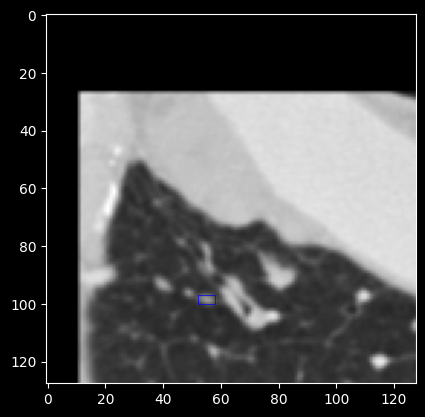

In [24]:


x0, y0, x1, y1 = 93, 47, 102, 57
#x0, y0, x1, y1 = 80, 70, 95, 87
from utils.Transform import single_box_generater
mask = nib.load(join("/data3/home/lishengyong/data/ssc_0802/new_slices/aug/masks", img_path[0]))
mask_arr = mask.get_fdata()
bboxes = single_box_generater(mask_arr)
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=0.5)) 
plt.imshow(img[..., 0] / 255, "gray")
bbox_raw = bboxes[1]
show_box(bbox_raw, plt.gca())
plt.show()


In [25]:
ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox_raw, mask_input=None, multimask_output=False)

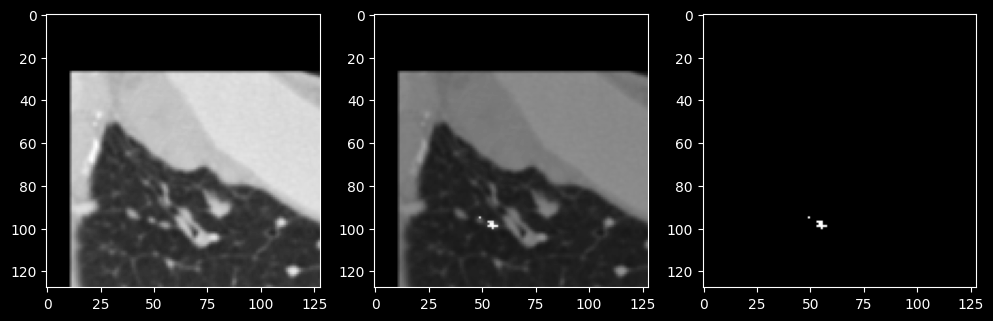

: 

In [26]:

plt.figure(figsize=(12, 8))
plt.subplot(131).imshow(img[...,0]/255, "gray")
plt.subplot(132).imshow(img[...,0]/255 + ori_sam_seg[0], "gray")
plt.subplot(133).imshow(ori_sam_seg[0], "gray")
plt.show()

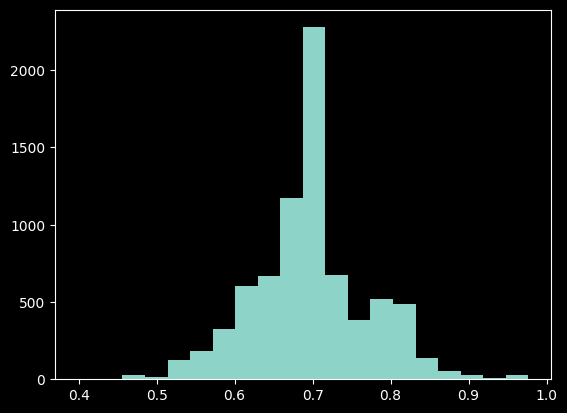

In [46]:
# 数据像素分布
length = []
for case in Path("/data3/home/lishengyong/data/ssc/h5.files/new_processed").iterdir():
    with h5py.File(case) as data:
        for i, roi_arr in enumerate(data["gts"]):
            
            #labels = skimage.measure.label(roi_arr, connectivity=2)
            spacing = data["new_spacings"][i][0]
            # props = skimage.measure.regionprops(np.uint8(roi_arr))
            try:
                length.append(spacing)
            except:
                pass
plt.hist(length, 20)
plt.show()

In [45]:
import cv2 as cv
# 算最长径
def dfs(matrix, x, y, visited, current_length):
    if x < 0 or x >= len(matrix) or y < 0 or y >= len(matrix[0]) or matrix[x][y] == 1 or visited[x][y]:
        return current_length
    
    visited[x][y] = True
    max_length = current_length
    
    # Explore the four adjacent cells
    max_length = max(max_length, dfs(matrix, x + 1, y, visited, current_length + 1))
    max_length = max(max_length, dfs(matrix, x - 1, y, visited, current_length + 1))
    max_length = max(max_length, dfs(matrix, x, y + 1, visited, current_length + 1))
    max_length = max(max_length, dfs(matrix, x, y - 1, visited, current_length + 1))
    
    visited[x][y] = False
    return max_length

def longest_path(matrix):
    
    rows, cols = len(matrix), len(matrix[0])
    visited = [[False for _ in range(cols)] for _ in range(rows)]
    max_length = 0
    
    for i in range(rows):
        for j in range(cols):
            if matrix[i][j] == 0:
                max_length = max(max_length, dfs(matrix, i, j, visited, 1))
    
    return max_length

# Example usage:
roi_arr =  np.array([
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [1, 1, 1, 1]
])
roi_arr = np.pad(roi_arr, (2,2))
print(roi_arr)
contours, hierarchy = cv.findContours(np.uint8(roi_arr), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
cnt = contours[0]
_, max_len = cv.minEnclosingCircle(cnt)
labels = skimage.measure.label(roi_arr, connectivity=2)
props = skimage.measure.regionprops(np.uint8(roi_arr))
print(max_len, props[0].axis_major_length)

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
2.5000998973846436 5.656854249492381


In [19]:
#拆分数据集
import json
import os
root = "/data3/home/lishengyong/data/ssc_0802/new_slices"
cases = os.listdir(root+"/images")
cases.sort()
print(len(cases))
keys = ["3D_image", "3D_mask"]
train_list, val_list, test_list = [], [], []
for i in cases[:int(len(cases) * 0.6)]:
    single_dict = dict()
    for key in keys:
        single_dict[key] = root+f"/{key}s/{i}"
    train_list.append(single_dict)
for i in cases[int(len(cases) * 0.6):int(len(cases) * 0.8)]:
    single_dict = dict()
    for key in keys:
        single_dict[key] = root+f"/{key}s/{i}"
    val_list.append(single_dict)
for i in cases[int(len(cases) * 0.8):]:
    single_dict = dict()
    for key in keys:
        single_dict[key] = root+f"/{key}s/{i}"
    test_list.append(single_dict)

data = {"train": train_list, "validation":val_list, "test":test_list} #"train": train_list, "validation":val_list, 
d = json.dumps(data)
with open(root+"/dataset_3d.json", "w") as f:
    f.write(d)
    

7582


In [5]:
# 检查偏差
import h5py
from pathlib import Path
from skimage import measure
from utils.SurfaceDice import compute_dice_coefficient
import numpy as np
def get_center(mask):
    a = measure.regionprops(mask)[0]
    box = a.bbox
    box_center = ((box[0]+box[2]) / 2,(box[1]+box[3]) / 2)
    zhixin = a.centroid
    return box_center, zhixin
def get_chaju(mask1, mask2):
    box1, zhixin1 = get_center(mask1)
    box2, zhixin2 = get_center(mask2)
    return (box1[0]-box2[0])**2+(box1[1]-box2[1])**2, (zhixin1[0]-zhixin2[0])**2+(zhixin1[1]-zhixin2[1])**2
    
files = [i for i in Path("/data3/home/lishengyong/data/ssc_0802/h5.files/processed_h5").iterdir()]
for case in files[3:]:
    print(case.name)
    dice, bbox_cha, zhixin_cha = 0,0,0
    with h5py.File(case, "r") as file:
        # for key in file.keys():
        #     print(key, file[key].shape)
        size = file["gts"].shape[0]
        k = 0
        masksize = file["masks"].shape[-1]
        print(masksize // 2)
        for i in range(size):
            
            gt = file["gts"][i].astype(np.int8)
            mask = file["masks"][i, ..., masksize // 2].astype(np.int8)
            if np.sum(mask) == 0 or np.sum(gt) == 0:
                continue
            try:
                dice += compute_dice_coefficient(gt, mask)
                box, zhixin = get_chaju(gt, mask)
            except:
                continue
            k += 1
            bbox_cha += box
            zhixin_cha += zhixin
        dice /= k
        bbox_cha /= k
        zhixin_cha /= k

    print(dice, bbox_cha, zhixin_cha, k)


lidc.center.nodule.after.adjust.h5
16
0.9842481828768054 15.559688581314878 15.440154319093947 2312
lung_false_positive_batch2.big.than.8.after.adjust.h5
32
0.6130807392857623 179.59558823529412 68.70682360546724 612
lung_false_positive_batch2.4_marker.1618.center.nodule.h5
16
0.99699691464982 2.343158890290038 1.936435494315417 1586
